<h1>News Classification with Sentence Transformers on the Ilur Dataset</h1>

<h2>Objective</h2>
<p>Build a multi-class classification model to predict the category of a news article from the Ilur dataset. The dataset consists of 7 distinct classes:</p>
<ul>
  <li><strong>economy</strong></li>
  <li><strong>accidents</strong></li>
  <li><strong>sport</strong></li>
  <li><strong>society</strong></li>
  <li><strong>politics</strong></li>
  <li><strong>weather</strong></li>
  <li><strong>culture</strong></li>
</ul>

<p><strong>Problem Statement:</strong> Given a news article as input, the model must classify it into one of the 7 categories listed above.</p>
<p><strong>Implementation:</strong> This classification task is implemented using <code>sentence-transformers</code> to generate text embeddings and train a classification model on top of these embeddings.</p>
<p><strong>Using Gradio for Visualization and Testing:</strong> To make the model more accessible and user-friendly, we have integrated <code>Gradio</code> for real-time testing and visualization. Gradio provides an interactive interface for users to input news articles, which are then classified by the trained model. The results are displayed immediately as a predicted news category.</p>

<h2>Importing Required Packages</h2>

<p>Before starting, ensure you have all the necessary packages installed. If a package is missing, you can install it using <code>pip</code>. Below is the list of required imports for this project:</p>

In [29]:
from sentence_transformers import SentenceTransformer

import gradio as gr

import torch 
import torch.nn.functional as F
from torch import Tensor

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from datasets import load_dataset

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os

<h2>Load Dataset and Move Model to GPU (if available)</h2>


In [30]:
dataset = load_dataset('Metric-AI/ILUR-news-text-classification-corpus-formatted')
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer('Metric-AI/armenian-text-embeddings-1',device=device)

No sentence-transformers model found with name Metric-AI/armenian-text-embeddings-1. Creating a new one with mean pooling.


In [31]:
print(dataset)
print(dataset['train'].unique('class'))

DatasetDict({
    train: Dataset({
        features: ['Sentence', 'class', 'source'],
        num_rows: 9821
    })
    test: Dataset({
        features: ['Sentence', 'class', 'source'],
        num_rows: 2445
    })
})
['economy', 'accidents', 'sport', 'society', 'politics', 'weather', 'culture']


<h2>Our Model is Not Symmetric</h2>

<p>You can add to the text <code>'query: '</code> or <code>'passage: '</code> or keep it as it is for experimentation, because it is not clear in classification tasks what prompt is generally preferable.</p>


In [32]:
def add_query_prefix(example):
    example['Sentence'] = 'query: ' + example['Sentence']
    return example

dataset = dataset.map(add_query_prefix)

<h2>Sentence Transformer for Embedding Generation</h2>

<p>The <code>sentence-transformers</code> package allows us to avoid elaborating on the model architecture. It automatically generates embeddings for train and test texts using the <code>encode</code> method. During the fitting step, since we have a labeled dataset, we train a supervised model. You can choose to fit either supervised or unsupervised models.</p>

<p>For more functionality and advanced usage, visit the official <a href="https://www.sbert.net/" target="_blank">Sentence Transformers page</a>.</p>


In [33]:
X_train = model.encode(dataset['train']['Sentence'])
y_train = dataset['train']['class']
X_test = model.encode(dataset['test']['Sentence'])
y_test = dataset['test']['class']

lda = LinearDiscriminantAnalysis()
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

lda.fit(X_train, y_train_encoded)

LinearDiscriminantAnalysis()

<h2>Model Evaluation on Train and Test Sets</h2>

<p>Evaluate the model on both the train and test sets. As observed, the model shows high performance on both, indicating that it fits well on the train set and generalizes effectively on the test set. Additionally, large language models (LLMs) are generally less prone to overfitting.</p>

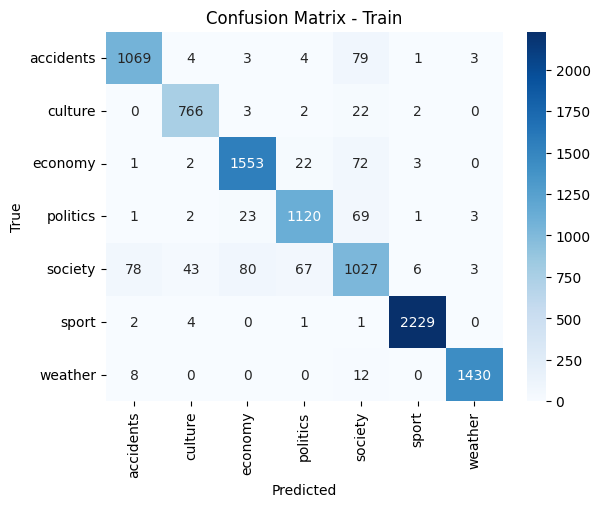

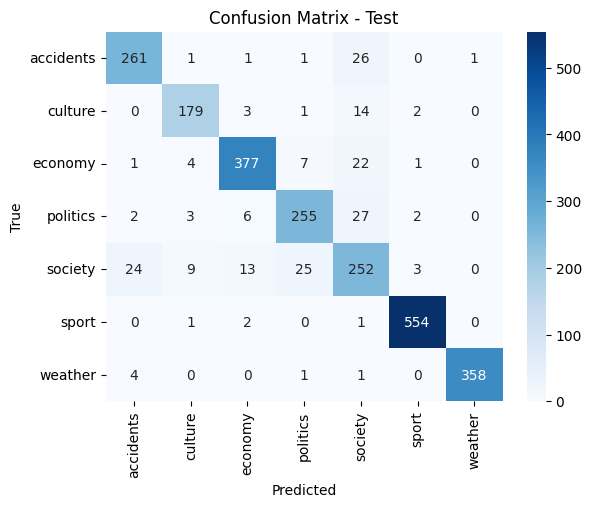

In [34]:
labels = label_encoder.classes_

y_pred_train = lda.predict(X_train)
cm_train = confusion_matrix(y_train_encoded, y_pred_train)

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Train')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

y_pred_test = lda.predict(X_test)
cm_test = confusion_matrix(y_test_encoded, y_pred_test)

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Test')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [35]:
print('Train results')
f1 = f1_score(y_train_encoded, y_pred_train, average='weighted')
print(f'F1 Score (Weighted): {f1:.2f}')

print('Test results')
f1 = f1_score(y_test_encoded, y_pred_test, average='weighted')
print(f'F1 Score (Weighted): {f1:.2f}')

Train results
F1 Score (Weighted): 0.94
Test results
F1 Score (Weighted): 0.92


<h2>Saving and Loading the Model</h2>

<p>We have trained and evaluated our model, and now we need to save it for future use. This is important because we don't want to retrain the model every time we run the code. By saving the model, we can load it whenever needed and make predictions without repeating the training process.</p>

<h3>Step 1: Saving the Model</h3>
<p>To save the model, we will create a folder named <strong>models</strong> (if it doesn't already exist) and store both the trained model and the label encoder inside it. This will help keep our saved models organized and easily accessible.</p>

<h3>Step 2: Loading the Model</h3>
<p>When we need to use the model again, we can load it from the <strong>models</strong> folder. This allows us to bypass the training process and immediately start making predictions with the previously trained model.</p>

<p>By following these steps, we can save and load the model effectively, ensuring that we don't need to retrain it every time, saving both time and computational resources.</p>


In [36]:
if not os.path.exists('models'):
    os.makedirs('models')

with open('models/lda_model.pkl', 'wb') as model_file:
    pickle.dump(lda, model_file)

with open('models/label_encoder.pkl', 'wb') as le_file:
    pickle.dump(label_encoder, le_file)

print("Model and Label Encoder saved successfully.")

Model and Label Encoder saved successfully.


In [37]:
with open('models/lda_model.pkl', 'rb') as model_file:
    lda = pickle.load(model_file)

with open('models/label_encoder.pkl', 'rb') as le_file:
    label_encoder = pickle.load(le_file)

print("Model and Label Encoder loaded successfully.")

Model and Label Encoder loaded successfully.


<h2>Using the Gradio Interface for News Article Classification</h2>

<p>Now that we have trained our model, we can interact with it through a Gradio interface. This allows us to input a news article and get a predicted category (e.g., Accident, Sports, Culture) for the article.</p>

<h3>Steps to Use the Interface</h3>

<ol>
    <li><strong>Input a News Article:</strong> In the input box labeled "📝 Enter News Article," type or paste a news article or sentence that you want to classify.</li>
    <li><strong>Submit the Input:</strong> After entering the article, click the "Submit" button to classify it. The model will process the text and predict the category.</li>
    <li><strong>View the Prediction:</strong> Once the article is processed, the predicted category will appear in the dropdown menu labeled "Predicted News Category." The model will display the most probable category for the article.</li>
    <li><strong>Clear the Input:</strong> If you'd like to input another article, simply click the "Clear" button to reset the input field and start over.</li>
</ol>

<h3>Example Usage</h3>
<p>For instance, if you input the following article:</p>
<blockquote>
    <p>"Բահրեյնի մայրաքաղաք Մանամայում ավարտվեց ծանրամարտի աշխարհի առաջնությունը։ Հայաստանի ծանրամարտի հավաքականը մեդալային հաշվարկում զբաղեցրեց 4-րդ տեղը։"</p>
</blockquote>
<p>The model might predict the category as <strong>Sport</strong>, based on the trained classification labels.</p>

<p>This Gradio interface makes it easy to quickly test and use the trained model without requiring any coding. Simply enter a sentence, click "Submit," and get the prediction!</p>

In [38]:
def classify(sentence):
    sentence_encoded = model.encode([sentence])
    prediction = lda.predict(sentence_encoded)
    return label_encoder.inverse_transform(prediction)[0]

output_labels = label_encoder.classes_

iface = gr.Interface(
    fn=classify, 
    inputs=gr.Textbox(label="📝 Enter News Article"), 
    outputs=gr.Dropdown(label="Predicted News Category", choices=output_labels.tolist()), 
    live=False,  
    clear_btn="Clear"  
)

iface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7871
* Running on public URL: https://2cb08bb80e7f70ee4c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
